## AAI-540
Zach Artman, Samantha Colbert-Neal, Nabeel Khan

In [3]:
!pip install -U sagemaker kagglehub pandas numpy scikit-learn matplotlib seaborn xgboost --quiet

In [4]:
import boto3
import sagemaker
from sagemaker import get_execution_role, Session
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.model_monitor import ModelQualityMonitor, DataCaptureConfig
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.parameters import ParameterString, ParameterFloat, ParameterInteger

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import time
from time import gmtime, strftime, sleep
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
sagemaker_session = Session()
region = boto3.Session().region_name
role = get_execution_role()
pipeline_session = PipelineSession()
default_bucket = sagemaker_session.default_bucket()
prefix = "hcp-marketing-campaign-prediction"

# S3 paths
data_prefix = f"{prefix}/data"
feature_store_prefix = f"{prefix}/feature-store"
model_prefix = f"{prefix}/models"
output_prefix = f"{prefix}/output"
monitoring_prefix = f"{prefix}/monitoring"

print(f"Region: {region}")
print(f"Role: {role}")
print(f"Default S3 Bucket: {default_bucket}")
print(f"Data Prefix: {data_prefix}")

Region: us-east-1
Role: arn:aws:iam::471112536460:role/LabRole
Default S3 Bucket: sagemaker-us-east-1-471112536460
Data Prefix: hcp-marketing-campaign-prediction/data


## Load Data Set

In [6]:
import kagglehub
import pandas as pd
import os

print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("arpit2712/digital-marketing-company")

# Load the first CSV file found
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {list(df.columns)}")


Dataset loaded successfully!
Dataset shape: (8000, 20)
Dataset columns: ['CustomerID', 'Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'AdvertisingPlatform', 'AdvertisingTool', 'Conversion']


In [7]:
df.head(10)


,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1
5,8005,25,Female,42925,Social Media,Awareness,9579.388247,0.153795,0.161316,6,2.125850,7.752831,95,5,8,0,3316,IsConfid,ToolConfid,1
6,8006,38,Female,25615,Referral,Awareness,7302.899852,0.040975,0.060977,42,1.753995,10.698672,54,14,3,6,930,IsConfid,ToolConfid,1
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.052878,0.188946,48,2.626015,2.987817,96,9,3,0,2983,IsConfid,ToolConfid,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.023536,0.112585,13,5.472843,14.287421,73,4,8,5,460,IsConfid,ToolConfid,1
9,8009,40,Male,130764,Social Media,Awareness,6229.193333,0.066641,0.169786,22,1.135665,4.613312,14,8,4,8,3789,IsConfid,ToolConfid,1


In [8]:
print(df.describe())

        CustomerID          Age         Income      AdSpend  ClickThroughRate  \
count   8000.00000  8000.000000    8000.000000  8000.000000       8000.000000   
mean   11999.50000    43.625500   84664.196750  5000.944830          0.154829   
std     2309.54541    14.902785   37580.387945  2838.038153          0.084007   
min     8000.00000    18.000000   20014.000000   100.054813          0.010005   
25%     9999.75000    31.000000   51744.500000  2523.221165          0.082635   
50%    11999.50000    43.000000   84926.500000  5013.440044          0.154505   
75%    13999.25000    56.000000  116815.750000  7407.989369          0.228207   
max    15999.00000    69.000000  149986.000000  9997.914781          0.299968   

       ConversionRate  WebsiteVisits  PagesPerVisit   TimeOnSite  \
count     8000.000000    8000.000000    8000.000000  8000.000000   
mean         0.104389      24.751625       5.549299     7.727718   
std          0.054878      14.312269       2.607358     4.228218  

In [9]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df)

Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []


In [10]:
# Save raw data to S3
os.makedirs('data', exist_ok=True)
raw_data_path = "data/raw_marketing_data.csv"
df.to_csv(raw_data_path, index=False)

# Upload to S3
s3_raw_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=raw_data_path,
    desired_s3_uri=f"s3://{default_bucket}/{data_prefix}/raw"
)
print(f"Raw data uploaded to: {s3_raw_data_uri}")

Raw data uploaded to: s3://sagemaker-us-east-1-471112536460/hcp-marketing-campaign-prediction/data/raw/raw_marketing_data.csv


## EDA

In [11]:
print(f"Columns in dataset: {df.columns.tolist()}")

Columns in dataset: ['CustomerID', 'Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'AdvertisingPlatform', 'AdvertisingTool', 'Conversion']


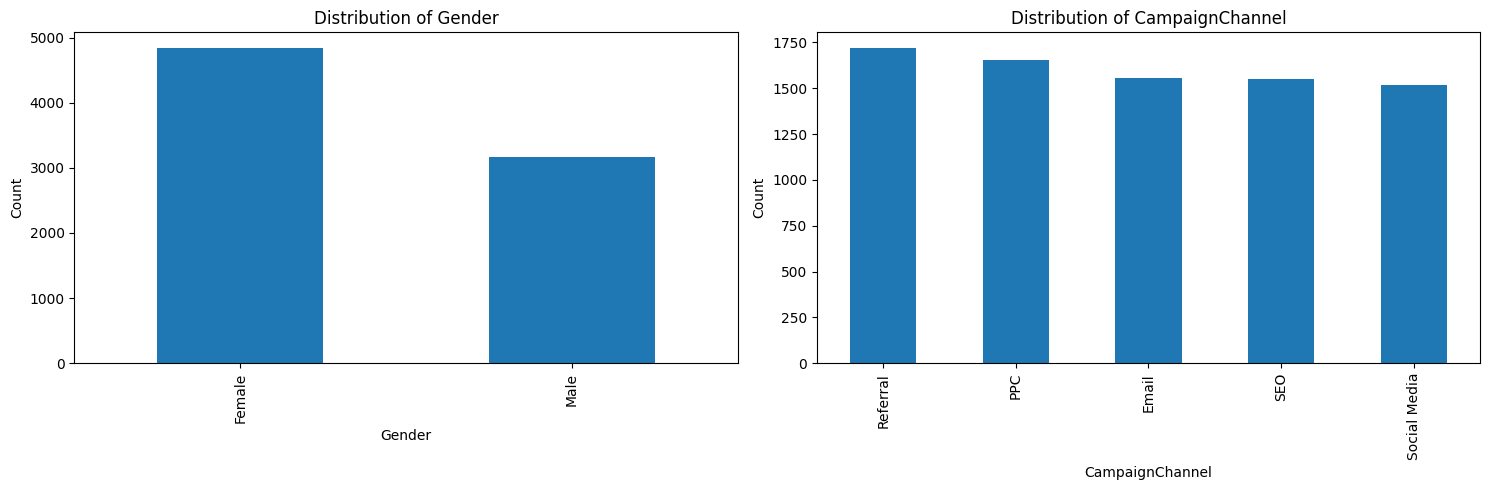

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    for i, col in enumerate(categorical_cols[:2]):
        if i < 2:
            df[col].value_counts().plot(kind='bar', ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            
plt.tight_layout()
plt.show()

Numeric columns: ['CustomerID', 'Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'Conversion']


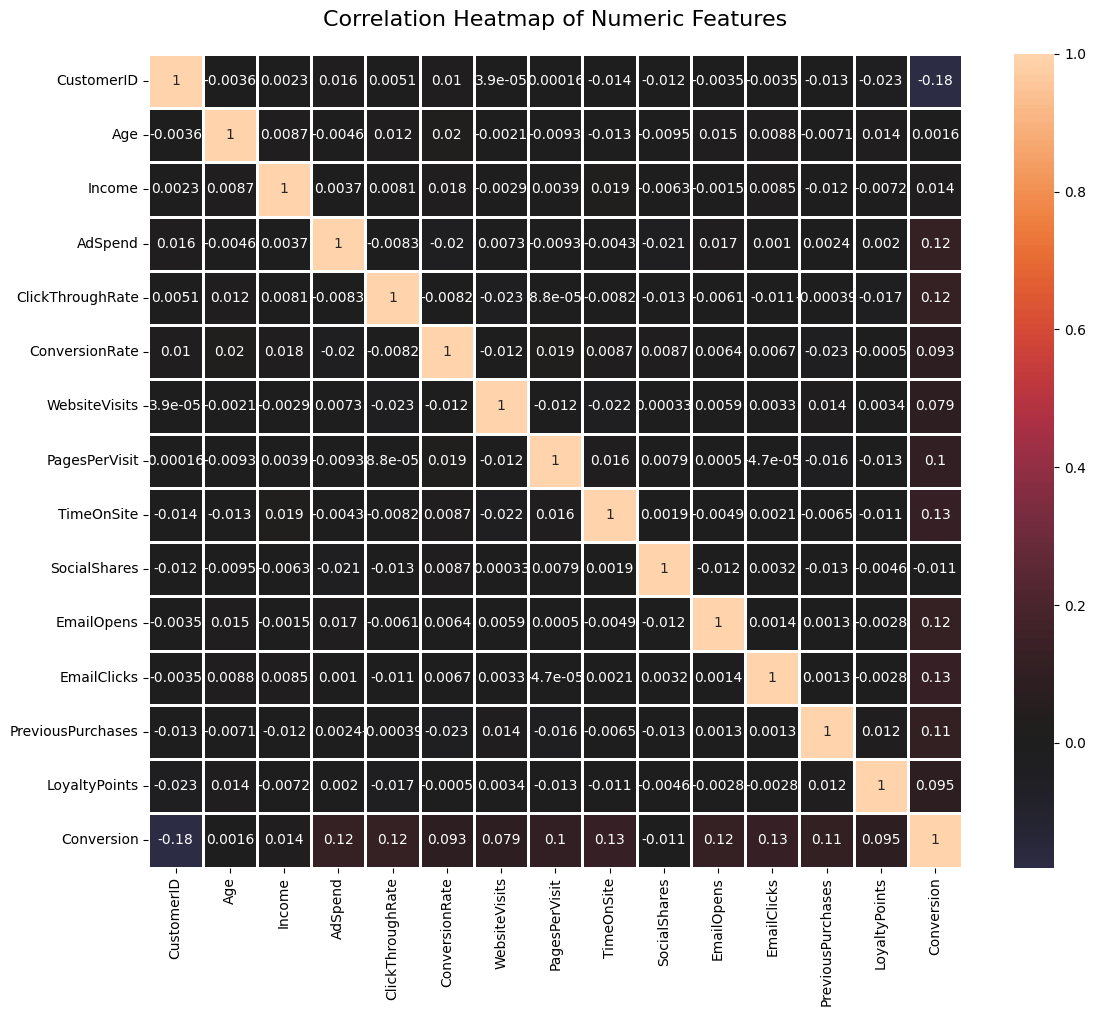

In [13]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns: {numeric_cols}")

if len(numeric_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, 
                center=0, ax=ax, square=True, linewidths=1)
    ax.set_title('Correlation Heatmap of Numeric Features', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

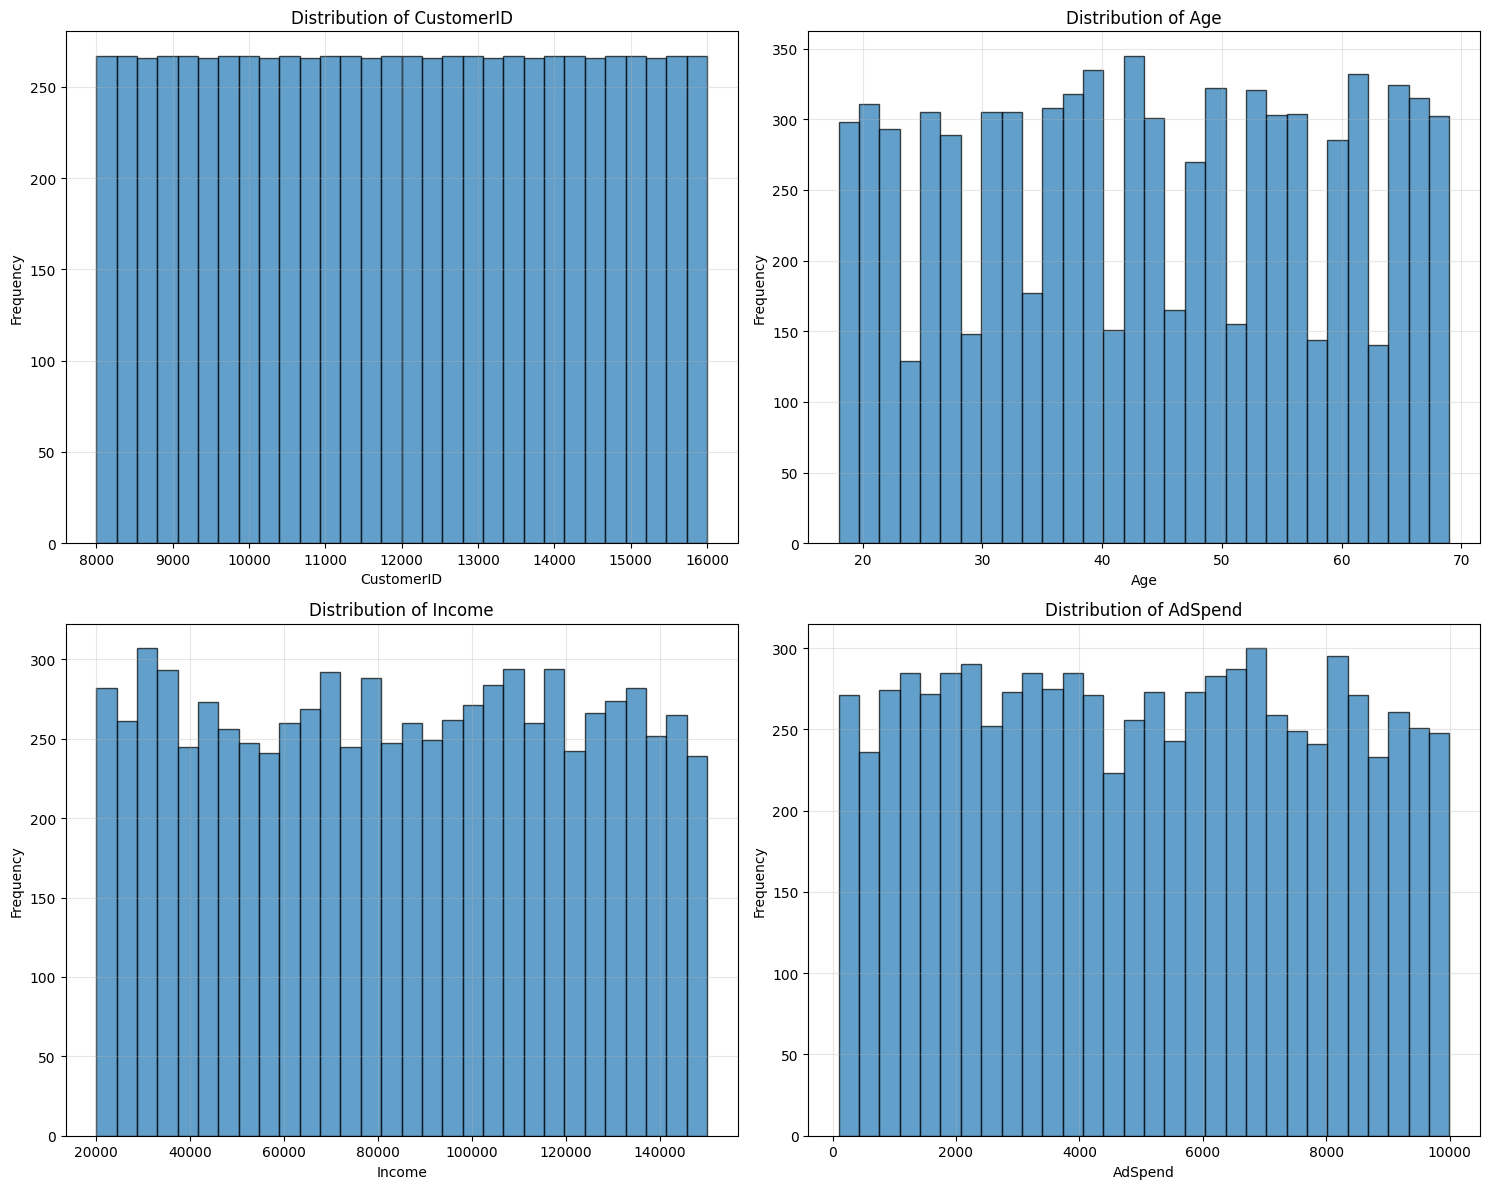

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols[:4]):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

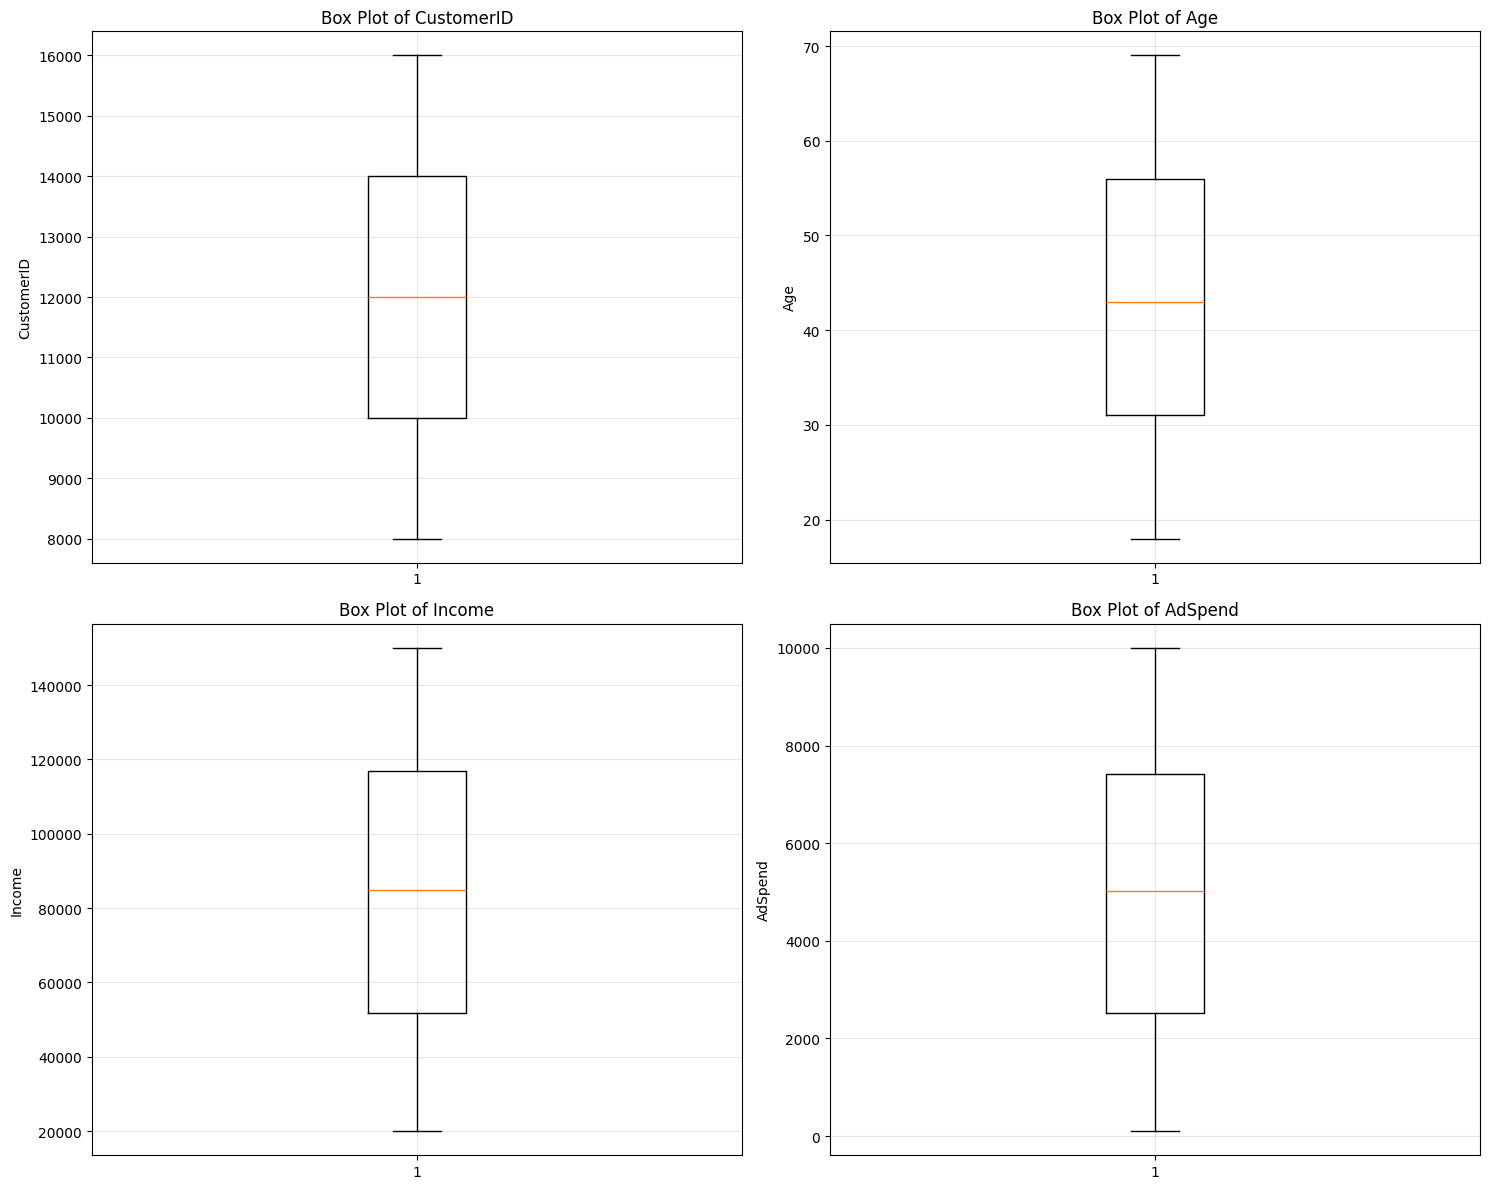

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols[:4]):
    axes[idx].boxplot(df[col].dropna())
    axes[idx].set_title(f'Box Plot of {col}', fontsize=12)
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Engineering

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

df_features = df.copy()

target_column = 'Conversion'
print(f"Target variable: {target_column}")
print(f"Target distribution:\n{df_features[target_column].value_counts()}")

categorical_features = ['Gender', 'CampaignChannel', 'CampaignType', 
                       'AdvertisingPlatform', 'AdvertisingTool']
numeric_features = ['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate',
                   'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares',
                   'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints']

print(f"\nCategorical features: {categorical_features}")
print(f"Numeric features: {numeric_features}")

current_time_sec = int(time.time())
df_features['event_time'] = float(current_time_sec)

df_features['id'] = df_features['CustomerID'].astype(int)
df_features = df_features.drop('CustomerID', axis=1)

print(f"\nFeature engineered dataset shape: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()}")


Target variable: Conversion
Target distribution:
Conversion
1    7012
0     988
Name: count, dtype: int64

Categorical features: ['Gender', 'CampaignChannel', 'CampaignType', 'AdvertisingPlatform', 'AdvertisingTool']
Numeric features: ['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints']

Feature engineered dataset shape: (8000, 21)
Columns: ['Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'AdvertisingPlatform', 'AdvertisingTool', 'Conversion', 'event_time', 'id']


In [17]:
for col in categorical_features:
    df_features[col] = df_features[col].astype('str').astype('string')

for col in numeric_features + [target_column]:
    df_features[col] = pd.to_numeric(df_features[col])

df_features['id'] = df_features['id'].astype('int64')
df_features['event_time'] = df_features['event_time'].astype('float64')

print("Data types after conversion:")
print(df_features.dtypes)
print(f"\nSample of prepared data:")
print(df_features.head())


Data types after conversion:
Age                             int64
Gender                 string[python]
Income                          int64
CampaignChannel        string[python]
CampaignType           string[python]
AdSpend                       float64
ClickThroughRate              float64
ConversionRate                float64
WebsiteVisits                   int64
PagesPerVisit                 float64
TimeOnSite                    float64
SocialShares                    int64
EmailOpens                      int64
EmailClicks                     int64
PreviousPurchases               int64
LoyaltyPoints                   int64
AdvertisingPlatform    string[python]
AdvertisingTool        string[python]
Conversion                      int64
event_time                    float64
id                              int64
dtype: object

Sample of prepared data:
   Age  Gender  Income CampaignChannel CampaignType      AdSpend  \
0   56  Female  136912    Social Media    Awareness  6497.870068 

In [18]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group_name = f"hcp-marketing-features-{strftime('%d-%H-%M-%S-2', gmtime())}"

# Create feature group
marketing_feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker_session
)

print(f"Feature Group Name: {feature_group_name}")

marketing_feature_group.load_feature_definitions(data_frame=df_features)

print("Feature definitions loaded successfully!")


Feature Group Name: hcp-marketing-features-18-08-36-13-2
Feature definitions loaded successfully!


In [19]:
s3_feature_store_uri = f"s3://{default_bucket}/{feature_store_prefix}"

print("Creating")
marketing_feature_group.create(
    s3_uri=s3_feature_store_uri,
    record_identifier_name='id',
    event_time_feature_name='event_time',
    role_arn=role,
    enable_online_store=True
)

print("Waiting for Feature Group completion")
status = marketing_feature_group.describe().get('FeatureGroupStatus')
while status == 'Creating':
    print(f"Status: {status}")
    time.sleep(10)
    status = marketing_feature_group.describe().get('FeatureGroupStatus')
print(f"created with status: {status}")

Creating
Waiting for Feature Group completion
Status: Creating
Status: Creating
Status: Creating
created with status: Created


In [20]:
marketing_feature_group.ingest(
    data_frame=df_features,
    max_workers=3,
    wait=True
)
print("Data ingestion complete!")

INFO:sagemaker.feature_store.feature_group:Started ingesting index 0 to 2667
INFO:sagemaker.feature_store.feature_group:Started ingesting index 2667 to 5334
INFO:sagemaker.feature_store.feature_group:Started ingesting index 5334 to 8000
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 2667 to 5334
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 5334 to 8000
INFO:sagemaker.feature_store.feature_group:Successfully ingested row 0 to 2667


Data ingestion complete!


In [21]:
featurestore_runtime = boto3.Session().client(
    service_name='sagemaker-featurestore-runtime',
    region_name=region
)

sample_id = str(df_features['id'].iloc[0])
record = featurestore_runtime.get_record(
    FeatureGroupName=feature_group_name,
    RecordIdentifierValueAsString=sample_id
)

print("Sample record from Feature Store:")
print(json.dumps(record, indent=2, default=str))

Sample record from Feature Store:
{
  "ResponseMetadata": {
    "RequestId": "534f8feb-4793-477f-a0d9-0caeee550d1b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "x-amzn-requestid": "534f8feb-4793-477f-a0d9-0caeee550d1b",
      "content-type": "application/json",
      "content-length": "1720",
      "date": "Sat, 18 Oct 2025 08:37:18 GMT"
    },
    "RetryAttempts": 0
  },
  "Record": [
    {
      "FeatureName": "Age",
      "ValueAsString": "56"
    },
    {
      "FeatureName": "Gender",
      "ValueAsString": "Female"
    },
    {
      "FeatureName": "Income",
      "ValueAsString": "136912"
    },
    {
      "FeatureName": "CampaignChannel",
      "ValueAsString": "Social Media"
    },
    {
      "FeatureName": "CampaignType",
      "ValueAsString": "Awareness"
    },
    {
      "FeatureName": "AdSpend",
      "ValueAsString": "6497.870068"
    },
    {
      "FeatureName": "ClickThroughRate",
      "ValueAsString": "0.043918511"
    },
    {
      "FeatureName": "Co

In [22]:
!mkdir -p code

In [23]:
%%writefile code/preprocessing.py
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--test-size', type=float, default=0.2)
    args, _ = parser.parse_known_args()
    
    input_data_path = '/opt/ml/processing/input'
    df = pd.read_csv(f'{input_data_path}/raw_marketing_data.csv')
    
    target_col = 'Conversion'
    categorical_features = ['Gender', 'CampaignChannel', 'CampaignType', 
                           'AdvertisingPlatform', 'AdvertisingTool']
    numeric_features = ['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate',
                       'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares',
                       'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints']
    
    df = df.drop('CustomerID', axis=1)
    
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le
    
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Split data: 60% train, 20% validation, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Save processed data (target as first column)
    train_data = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
    val_data = pd.concat([y_val.reset_index(drop=True), X_val.reset_index(drop=True)], axis=1)
    test_data = pd.concat([y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
    
    train_data.to_csv('/opt/ml/processing/train/train.csv', header=False, index=False)
    val_data.to_csv('/opt/ml/processing/validation/validation.csv', header=False, index=False)
    test_data.to_csv('/opt/ml/processing/test/test.csv', header=False, index=False)
    
    # Save preprocessing objects
    joblib.dump(scaler, '/opt/ml/processing/model/scaler.joblib')
    joblib.dump(le_dict, '/opt/ml/processing/model/label_encoders.joblib')
    
    print(f'Preprocessing complete')
    print(f'Train: {train_data.shape}, Val: {val_data.shape}, Test: {test_data.shape}')


Overwriting code/preprocessing.py


In [47]:
sklearn_processor = SKLearnProcessor(
    framework_version='1.2-1',
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='hcp-marketing-preprocessing',
    role=role,
    sagemaker_session=sagemaker_session
)

print("Starting preprocessing job...")
sklearn_processor.run(
    code='code/preprocessing.py',
    inputs=[
        ProcessingInput(
            source=s3_raw_data_uri,
            destination='/opt/ml/processing/input'
        )
    ],
    outputs=[
        ProcessingOutput(output_name='train', source='/opt/ml/processing/train'),
        ProcessingOutput(output_name='validation', source='/opt/ml/processing/validation'),
        ProcessingOutput(output_name='test', source='/opt/ml/processing/test'),
        ProcessingOutput(output_name='model', source='/opt/ml/processing/model')
    ]
)

print("Preprocessing job complete")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating processing-job with name hcp-marketing-preprocessing-2025-10-18-11-29-21-575


Starting preprocessing job...
...........Preprocessing complete
Train: (4800, 19), Val: (1600, 19), Test: (1600, 19)

Preprocessing job complete


In [48]:
# Get preprocessing job outputs
preprocessing_job_description = sklearn_processor.jobs[-1].describe()
train_data_s3_uri = preprocessing_job_description['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
val_data_s3_uri = preprocessing_job_description['ProcessingOutputConfig']['Outputs'][1]['S3Output']['S3Uri']
test_data_s3_uri = preprocessing_job_description['ProcessingOutputConfig']['Outputs'][2]['S3Output']['S3Uri']

print(f"Training data: {train_data_s3_uri}")
print(f"Validation data: {val_data_s3_uri}")
print(f"Test data: {test_data_s3_uri}")

Training data: s3://sagemaker-us-east-1-471112536460/hcp-marketing-preprocessing-2025-10-18-11-29-21-575/output/train
Validation data: s3://sagemaker-us-east-1-471112536460/hcp-marketing-preprocessing-2025-10-18-11-29-21-575/output/validation
Test data: s3://sagemaker-us-east-1-471112536460/hcp-marketing-preprocessing-2025-10-18-11-29-21-575/output/test


## Logistic Regression Model

In [49]:
%%writefile code/train_logistic.py
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib
import json

if __name__ == '__main__':
    train_df = pd.read_csv('/opt/ml/input/data/train/train.csv', header=None)
    X_train = train_df.iloc[:, 1:]
    y_train = train_df.iloc[:, 0]
    
    # Train Logistic Regression
    print("Training Logistic Regression model...")
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Save model
    model_path = os.path.join('/opt/ml/model', 'model.joblib')
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

Overwriting code/train_logistic.py


In [50]:
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator_lr = SKLearn(
    entry_point='train_logistic.py',
    source_dir='code',
    framework_version='1.2-1',
    instance_type='ml.m5.xlarge',
    role=role,
    sagemaker_session=sagemaker_session,
    base_job_name='hcp-logistic-regression'
)

print("Starting Logistic Regression training...")
sklearn_estimator_lr.fit({
    'train': train_data_s3_uri,
    'validation': val_data_s3_uri
})
print("Logistic Regression training complete!")

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: hcp-logistic-regression-2025-10-18-11-32-24-792


Starting Logistic Regression training...
2025-10-18 11:32:26 Starting - Starting the training job...
2025-10-18 11:32:57 Downloading - Downloading input data...
2025-10-18 11:33:17 Downloading - Downloading the training image......
2025-10-18 11:34:23 Training - Training image download completed. Training in progress.
2025-10-18 11:34:23 Uploading - Uploading generated training model/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-18 11:34:18,542 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-10-18 11:34:18,547 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-10-18 11:34:18,550 sagemaker-training-toolkit INFO 

## Random Forest

In [51]:
%%writefile code/train_random_forest.py
import argparse
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib

if __name__ == '__main__':
    train_df = pd.read_csv('/opt/ml/input/data/train/train.csv', header=None)
    X_train = train_df.iloc[:, 1:]
    y_train = train_df.iloc[:, 0]
    
    print("Training Random Forest")
    model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    model_path = os.path.join('/opt/ml/model', 'model.joblib')
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")
    
    feature_importance = pd.DataFrame({
        'feature': [f'feature_{i}' for i in range(X_train.shape[1])],
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Important Features:")
    print(feature_importance.head(10))

Overwriting code/train_random_forest.py


In [ ]:
sklearn_estimator_rf = SKLearn(
    entry_point='train_random_forest.py',
    source_dir='code',
    framework_version='1.2-1',
    instance_type='ml.m5.xlarge',
    role=role,
    sagemaker_session=sagemaker_session,
    base_job_name='hcp-random-forest'
)

print("Starting Random Forest train")
sklearn_estimator_rf.fit({
    'train': train_data_s3_uri,
    'validation': val_data_s3_uri
})
print("Random Forest training complete")

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: hcp-random-forest-2025-10-18-11-35-23-846


Starting Random Forest train
2025-10-18 11:35:25 Starting - Starting the training job...
2025-10-18 11:35:58 Downloading - Downloading input data...
2025-10-18 11:36:18 Downloading - Downloading the training image......
2025-10-18 11:37:19 Training - Training image download completed. Training in progress.
2025-10-18 11:37:19 Uploading - Uploading generated training model/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-18 11:37:14,901 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-10-18 11:37:14,906 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-10-18 11:37:14,908 sagemaker-training-toolkit INFO     No Neuro

## Eval

In [53]:
from sagemaker.processing import ScriptProcessor

script_processor = ScriptProcessor(
    image_uri=sklearn_estimator_rf.training_image_uri(),
    command=['python3'],
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='hcp-model-evaluation',
    role=role,
    sagemaker_session=sagemaker_session
)

models_to_evaluate = [
    ('Logistic Regression', sklearn_estimator_lr.model_data),
    ('Random Forest', sklearn_estimator_rf.model_data)
]

evaluation_results = {}

for model_name, model_data in models_to_evaluate:
    print(f"Evaluating {model_name}")
    
    script_processor.run(
        code='code/eval.py',
        inputs=[
            ProcessingInput(source=model_data, destination='/opt/ml/processing/model'),
            ProcessingInput(source=test_data_s3_uri, destination='/opt/ml/processing/test')
        ],
        outputs=[
            ProcessingOutput(output_name='evaluation', source='/opt/ml/processing/evaluation')
        ],
        arguments=['--model-name', model_name]
    )
    
    # Get evaluation results
    job_description = script_processor.jobs[-1].describe()
    eval_output_uri = job_description['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
    
    # Download and parse results
    eval_json = sagemaker.s3.S3Downloader.read_file(f'{eval_output_uri}/evaluation.json')
    evaluation_results[model_name] = json.loads(eval_json)


INFO:sagemaker:Creating processing-job with name hcp-model-evaluation-2025-10-18-11-49-27-926


Evaluating Logistic Regression
...............
..Evaluating Random Forest


INFO:sagemaker:Creating processing-job with name hcp-model-evaluation-2025-10-18-11-52-19-619


...............
..

In [54]:
%%writefile code/eval.py
import argparse
import os
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tarfile

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model-name', type=str, required=True)
    args, _ = parser.parse_known_args()
    
    model_path = '/opt/ml/processing/model/model.tar.gz'
    with tarfile.open(model_path, 'r:gz') as tar:
        tar.extractall('/opt/ml/processing/model/')
    
    model = joblib.load('/opt/ml/processing/model/model.joblib')
    
    test_df = pd.read_csv('/opt/ml/processing/test/test.csv', header=None)
    X_test = test_df.iloc[:, 1:]
    y_test = test_df.iloc[:, 0]
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'model_name': args.model_name,
        'accuracy': float(accuracy_score(y_test, y_pred)),
        'precision': float(precision_score(y_test, y_pred, average='weighted', zero_division=0)),
        'recall': float(recall_score(y_test, y_pred, average='weighted', zero_division=0)),
        'f1_score': float(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    }
    
    output_dir = '/opt/ml/processing/evaluation'
    os.makedirs(output_dir, exist_ok=True)
    
    with open(f'{output_dir}/evaluation.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    
    report = classification_report(y_test, y_pred)
    with open(f'{output_dir}/classification_report.txt', 'w') as f:
        f.write(report)


Overwriting code/eval.py


                              model_name  accuracy precision    recall  \
Logistic Regression  Logistic Regression  0.890625  0.874015  0.890625   
Random Forest              Random Forest  0.890625  0.887068  0.890625   

                     f1_score  
Logistic Regression  0.859568  
Random Forest        0.852738  


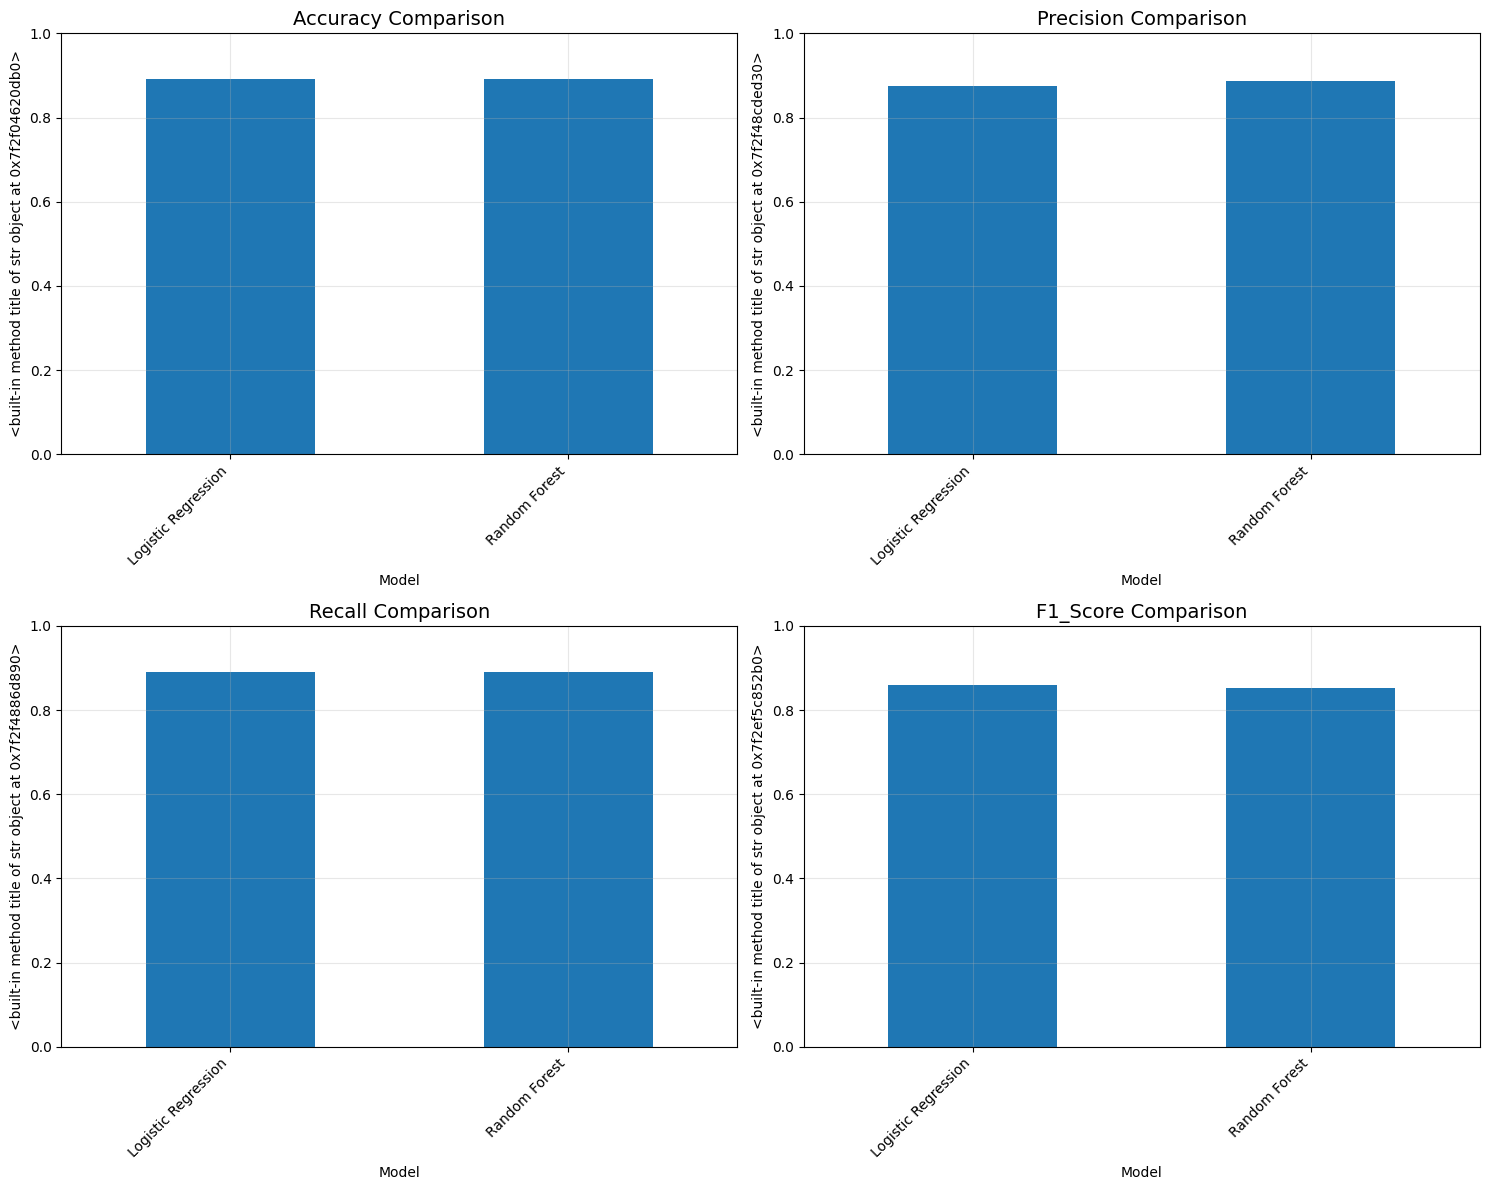

Best Model: Logistic Regression
F1-Score: 0.8596


In [55]:
comparison_df = pd.DataFrame(evaluation_results).T
print(comparison_df)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    comparison_df[metric].plot(kind='bar', ax=ax)
    ax.set_title(f'{metric.title()} Comparison', fontsize=14)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.title)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

best_model_name = comparison_df['f1_score'].idxmax()
print(f"Best Model: {best_model_name}")
print(f"F1-Score: {comparison_df.loc[best_model_name, 'f1_score']:.4f}")


# Model Deployment

In [56]:
model_map = {
    'Logistic Regression': sklearn_estimator_lr.model_data,
    'Random Forest': sklearn_estimator_rf.model_data
}
best_model_s3 = model_map[best_model_name]
print(f'Best model artifact: {best_model_s3}')

preprocess_artifacts_s3 = preprocessing_job_description['ProcessingOutputConfig']['Outputs'][3]['S3Output']['S3Uri']
print(f'Preprocessing artifacts: {preprocess_artifacts_s3}')


Best model artifact: s3://sagemaker-us-east-1-471112536460/hcp-logistic-regression-2025-10-18-11-32-24-792/output/model.tar.gz
Preprocessing artifacts: s3://sagemaker-us-east-1-471112536460/hcp-marketing-preprocessing-2025-10-18-11-29-21-575/output/model


In [57]:
!mkdir -p deploy_bundle && rm -rf deploy_bundle/*
from sagemaker.s3 import S3Downloader, S3Uploader
import tarfile, os, shutil, joblib

local_model_tar = 'deploy_bundle/model.tar.gz'
local_model_dir = 'deploy_bundle/model_dir'
local_pre_dir = 'deploy_bundle/pre_dir'
os.makedirs(local_model_dir, exist_ok=True)
os.makedirs(local_pre_dir, exist_ok=True)

S3Downloader.download(best_model_s3, 'deploy_bundle/')
S3Downloader.download(preprocess_artifacts_s3, local_pre_dir)

with tarfile.open(local_model_tar, 'r:gz') as tar:
    tar.extractall(local_model_dir)

shutil.copy(os.path.join(local_pre_dir, 'scaler.joblib'), os.path.join(local_model_dir, 'scaler.joblib'))
shutil.copy(os.path.join(local_pre_dir, 'label_encoders.joblib'), os.path.join(local_model_dir, 'label_encoders.joblib'))

repacked_tar = 'deploy_bundle/model_repacked.tar.gz'
with tarfile.open(repacked_tar, 'w:gz') as tar:
    for f in os.listdir(local_model_dir):
        tar.add(os.path.join(local_model_dir, f), arcname=f)

deploy_model_s3 = S3Uploader.upload(repacked_tar, f"s3://{default_bucket}/{model_prefix}/best")
print(f'Deploy bundle uploaded: {deploy_model_s3}')


Deploy bundle uploaded: s3://sagemaker-us-east-1-471112536460/hcp-marketing-campaign-prediction/models/best/model_repacked.tar.gz


In [58]:
%%writefile code/inference.py
import json, joblib, numpy as np, pandas as pd, os, glob

FEATURE_COLUMNS = ['Age','Gender','Income','CampaignChannel','CampaignType',
                   'AdSpend','ClickThroughRate','ConversionRate','WebsiteVisits',
                   'PagesPerVisit','TimeOnSite','SocialShares','EmailOpens',
                   'EmailClicks','PreviousPurchases','LoyaltyPoints',
                   'AdvertisingPlatform','AdvertisingTool']

def _load_model(model_dir):
    cands = ['model.joblib','model.pkl','estimator.joblib','estimator.pkl']
    for p in cands:
        fp = os.path.join(model_dir, p)
        if os.path.exists(fp):
            return joblib.load(fp)
    any_joblib = glob.glob(os.path.join(model_dir, '*.joblib')) + glob.glob(os.path.join(model_dir, '*.pkl'))
    if any_joblib:
        return joblib.load(any_joblib[0])
    raise RuntimeError('Model file not found')

def model_fn(model_dir):
    model = _load_model(model_dir)
    scaler = joblib.load(os.path.join(model_dir,'scaler.joblib'))
    encoders = joblib.load(os.path.join(model_dir,'label_encoders.joblib'))
    return {'model': model, 'scaler': scaler, 'encoders': encoders}

def input_fn(request_body, request_content_type='application/json'):
    if request_content_type == 'application/json':
        payload = json.loads(request_body)
        recs = payload if isinstance(payload, list) else payload.get('instances', [payload])
        return pd.DataFrame(recs)
    raise ValueError('Unsupported content type')

def _safe_encode(series, le):
    classes = {c:i for i,c in enumerate(le.classes_)}
    return series.astype(str).map(classes).fillna(-1).astype(int)

def _prep(df, encoders, scaler):
    df = df.copy()
    for c in ['Gender','CampaignChannel','CampaignType','AdvertisingPlatform','AdvertisingTool']:
        df[c] = _safe_encode(df[c], encoders[c])
    num = ['Age','Income','AdSpend','ClickThroughRate','ConversionRate','WebsiteVisits',
           'PagesPerVisit','TimeOnSite','SocialShares','EmailOpens','EmailClicks',
           'PreviousPurchases','LoyaltyPoints']
    df[num] = scaler.transform(df[num])
    df = df.reindex(columns=FEATURE_COLUMNS)
    return df.values

def predict_fn(df, art):
    X = _prep(df, art['encoders'], art['scaler'])
    m = art['model']
    if hasattr(m,'predict_proba'):
        s = m.predict_proba(X)[:,1]
    else:
        s = m.decision_function(X)
        if s.ndim==1: pass
        else: s = s[:,0]
    y = (s >= 0.5).astype(int)
    return {'predictions': y.tolist(), 'scores': s.tolist()}

def output_fn(prediction, accept='application/json'):
    return json.dumps(prediction), accept



Overwriting code/inference.py


In [59]:
!rm -f deploy_bundle/model_repacked.tar.gz
with tarfile.open('deploy_bundle/model_repacked.tar.gz', 'w:gz') as tar:
    for f in os.listdir('deploy_bundle/model_dir'):
        tar.add(os.path.join('deploy_bundle/model_dir', f), arcname=f)

from sagemaker.s3 import S3Uploader
deploy_model_s3 = S3Uploader.upload('deploy_bundle/model_repacked.tar.gz', f"s3://{default_bucket}/{model_prefix}/best")
deploy_model_s3

's3://sagemaker-us-east-1-471112536460/hcp-marketing-campaign-prediction/models/best/model_repacked.tar.gz'

In [60]:
from sagemaker.sklearn.model import SKLearnModel
from time import strftime, gmtime

endpoint_name = f"hcp-best-model-{strftime('%d-%H-%M-%S', gmtime())}"

sk_model = SKLearnModel(
    model_data=deploy_model_s3,
    role=role,
    entry_point='inference.py',
    source_dir='code',
    framework_version='1.2-1',
    sagemaker_session=sagemaker_session
)

predictor = sk_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name=endpoint_name
)
endpoint_name

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2025-10-18-11-56-46-353
INFO:sagemaker:Creating endpoint-config with name hcp-best-model-18-11-56-45
INFO:sagemaker:Creating endpoint with name hcp-best-model-18-11-56-45


------!

'hcp-best-model-18-11-56-45'

In [61]:
import tarfile
with tarfile.open('deploy_bundle/model.tar.gz','r:gz') as t:
    print(t.getnames())

['model.joblib']


In [62]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

In [63]:
FEATURE_COLUMNS = [
    'Age','Gender','Income','CampaignChannel','CampaignType','AdSpend',
    'ClickThroughRate','ConversionRate','WebsiteVisits','PagesPerVisit',
    'TimeOnSite','SocialShares','EmailOpens','EmailClicks','PreviousPurchases',
    'LoyaltyPoints','AdvertisingPlatform','AdvertisingTool'
]

sample = df.iloc[[0]][FEATURE_COLUMNS].to_dict(orient='records')
res = predictor.predict(sample)
print(res)

{'predictions': [1], 'scores': [0.6705589595305114]}


In [64]:
import boto3, time
sm = boto3.client('sagemaker')

while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(status)
    if status in ['InService', 'Failed']:
        break
    time.sleep(60)

InService


# Model Monitoring

In [65]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_s3 = "s3://{default_bucket}/{model_prefix}/datacapture"
capture_cfg = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_s3,
    capture_options=["Input", "Output"],
)

In [67]:
import boto3
sm = boto3.client("sagemaker")

ep_desc = sm.describe_endpoint(EndpointName=endpoint_name)
cfg_old = ep_desc["EndpointConfigName"]

mdl_desc = sm.describe_endpoint_config(EndpointConfigName=cfg_old)
pv = mdl_desc["ProductionVariants"][0]
model_name = pv["ModelName"]
instance_type = pv["InstanceType"]
variant_name = pv["VariantName"]
initial_instance_count = pv["InitialInstanceCount"]

cfg_new = f"{endpoint_name}-cfg-capture"

sm.create_endpoint_config(
    EndpointConfigName=cfg_new,
    ProductionVariants=[
        {
            "ModelName": model_name,
            "VariantName": variant_name,
            "InitialInstanceCount": initial_instance_count,
            "InstanceType": instance_type,
            "InitialVariantWeight": 1.0,
        },
    ],
    DataCaptureConfig=capture_cfg._to_request_dict(),
)

sm.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=cfg_new)
print(cfg_new, sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"])

hcp-best-model-18-11-56-45-cfg-capture Updating


In [68]:
payload = df.sample(5, random_state=8)[FEATURE_COLUMNS].to_dict(orient="records")
_ = predictor.predict(payload)

In [69]:
import boto3
s3 = boto3.client("s3")

bucket = default_bucket
prefix = f"{model_prefix}/datacapture"
resp = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

for c in resp.get("Contents", []):
    print(c["Key"], c["LastModified"])

hcp-marketing-campaign-prediction/models/datacapture/hcp-best-model-18-06-06-01/AllTraffic/2025/10/18/07/26-24-844-77fce1df-09a8-4f95-8bab-b49a8f1522ed.jsonl 2025-10-18 07:27:27+00:00


In [70]:
import json, os, boto3, tempfile, pathlib

s3 = boto3.client("s3")
baseline_prefix = f"{model_prefix}/baseline"
os.makedirs("baseline", exist_ok=True)
baseline_file = "baseline/baseline.jsonl"

with open(baseline_file, "w") as f:
    for r in df.sample(100, random_state=42).to_dict(orient="records"):
        f.write(json.dumps(r) + "\n")

s3.upload_file(baseline_file, default_bucket, f"{baseline_prefix}/input/baseline.jsonl")
baseline_s3 = f"s3://{default_bucket}/{baseline_prefix}/input/baseline.jsonl"
baseline_s3

's3://sagemaker-us-east-1-471112536460/hcp-marketing-campaign-prediction/models/baseline/input/baseline.jsonl'

In [71]:
import sagemaker
from sagemaker.model_monitor import DefaultModelMonitor, DatasetFormat
from time import strftime, gmtime
import boto3, time

role  = sagemaker.get_execution_role()
sess  = sagemaker.Session()
sm    = boto3.client("sagemaker")

monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=sess,
)

baseline_job    = f"fdg-baseline-{strftime('%d-%H-%M-%S', gmtime())}"
baseline_output = f"s3://{default_bucket}/{model_prefix}/baseline/output"

monitor.suggest_baseline(
    job_name=baseline_job,
    baseline_dataset=baseline_s3,
    dataset_format=DatasetFormat.json(),
    output_s3_uri=baseline_output,
    wait=False,
    logs=False,
)

def baseline_status(name):
    return sm.describe_processing_job(ProcessingJobName=name)["ProcessingJobStatus"]

while True:
    s = baseline_status(baseline_job)
    print(s)
    if s in ("Completed", "Failed", "Stopped"):
        break
    time.sleep(15)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating processing-job with name fdg-baseline-18-13-25-37


InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Failed


In [72]:
import boto3, json
sm = boto3.client("sagemaker")

desc = sm.describe_processing_job(ProcessingJobName=baseline_job)
print("Status:", desc["ProcessingJobStatus"])
print("FailureReason:", desc.get("FailureReason"))
print("ExitMessage:", desc.get("ExitMessage"))
print("Logs:", desc["ProcessingResources"]["ClusterConfig"])

Status: Failed
FailureReason: AlgorithmError: Error: Could not find any json file under directory /opt/ml/processing/input/baseline_dataset_input. Please verify if the provided dataset path is correct or if data capturing in your Endpoint is turned on., exit code: 255
ExitMessage: Error: Could not find any json file under directory /opt/ml/processing/input/baseline_dataset_input. Please verify if the provided dataset path is correct or if data capturing in your Endpoint is turned on.
Logs: {'InstanceCount': 1, 'InstanceType': 'ml.m5.large', 'VolumeSizeInGB': 20}


In [73]:
import boto3
s3 = boto3.client("s3")

csv_path = "baseline/baseline.csv"
df[FEATURE_COLUMNS].dropna().to_csv(csv_path, index=False, header=True)

key = f"{model_prefix}/baseline/input/baseline.csv"
s3.upload_file(csv_path, default_bucket, key)
baseline_s3 = f"s3://{default_bucket}/{key}"
baseline_s3

's3://sagemaker-us-east-1-471112536460/hcp-marketing-campaign-prediction/models/baseline/input/baseline.csv'

In [ ]:
import sagemaker, boto3, time
from sagemaker.model_monitor import DefaultModelMonitor, DatasetFormat
from time import strftime, gmtime

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
sm = boto3.client("sagemaker")

monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=sess,
)

baseline_job    = f"fdg-baseline-{strftime('%d-%H-%M-%S', gmtime())}"
baseline_output = f"s3://{default_bucket}/{model_prefix}/baseline/output"

monitor.suggest_baseline(
    job_name=baseline_job,
    baseline_dataset=baseline_s3,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_output,
    wait=False,
    logs=False,
)

def status(name):
    return sm.describe_processing_job(ProcessingJobName=name)["ProcessingJobStatus"]

while True:
    s = status(baseline_job)
    print(s)
    if s in ("Completed", "Failed", "Stopped"):
        break
    time.sleep(15)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating processing-job with name fdg-baseline-18-13-35-26


InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [78]:
from sagemaker.model_monitor import CronExpressionGenerator

baseline_stats_s3 = f"s3://{default_bucket}/{model_prefix}/baseline/output/statistics.json"
baseline_const_s3 = f"s3://{default_bucket}/{model_prefix}/baseline/output/constraints.json"

schedule_name = f"{endpoint_name}-data-quality-daily"

monitor.create_monitoring_schedule(
    monitor_schedule_name=schedule_name,
    endpoint_input=endpoint_name,
    output_s3_uri=f"s3://{default_bucket}/{model_prefix}/monitoring/output",
    statistics=baseline_stats_s3,
    constraints=baseline_const_s3,
    schedule_cron_expression=CronExpressionGenerator.daily(hour=2),
)
schedule_name

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: hcp-best-model-18-11-56-45-data-quality-daily


'hcp-best-model-18-11-56-45-data-quality-daily'

In [79]:
import boto3
sm = boto3.client("sagemaker")

def schedule_status(name):
    return sm.describe_monitoring_schedule(MonitoringScheduleName=name)["MonitoringScheduleStatus"]

print(schedule_status(schedule_name))

Scheduled


In [1]:
import boto3, sagemaker, pandas as pd
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

endpoint_name = "hcp-best-model-18-11-56-45"  # replace with your actual endpoint name
default_bucket = sagemaker.Session().default_bucket()
model_prefix = "model-monitor-demo"  # or whatever prefix you used earlier

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker.Session(),
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

FEATURE_COLUMNS = [
    'Age','Gender','Income','CampaignChannel','CampaignType','AdSpend',
    'ClickThroughRate','ConversionRate','WebsiteVisits','PagesPerVisit',
    'TimeOnSite','SocialShares','EmailOpens','EmailClicks','PreviousPurchases',
    'LoyaltyPoints','AdvertisingPlatform','AdvertisingTool'
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
df = pd.read_csv("raw_marketing_data.csv")
print(df.shape)
df.head()

batch = df.sample(150, random_state=33)[FEATURE_COLUMNS].to_dict(orient="records")
for i in range(0, len(batch), 25):
    _ = predictor.predict(batch[i:i+25])
len(batch)

(8000, 20)


150

In [3]:
import boto3
s3 = boto3.client("s3")

cap_prefix = f"{model_prefix}/datacapture"
resp = s3.list_objects_v2(Bucket=default_bucket, Prefix=cap_prefix)
if "Contents" not in resp or len(resp["Contents"]) == 0:
    batch = df.sample(120, random_state=17)[FEATURE_COLUMNS].to_dict(orient="records")
    for i in range(0, len(batch), 25):
        _ = predictor.predict(batch[i:i+25])

In [ ]:
import boto3, time

schedule_name = f"hcp-best-model-18-11-56-45-data-quality-daily"
print(schedule_name)

sm = boto3.client("sagemaker")

sm.start_monitoring_schedule(MonitoringScheduleName=schedule_name)

while True:
    execs = sm.list_monitoring_executions(
        MonitoringScheduleName=schedule_name, MaxResults=1
    )["MonitoringExecutionSummaries"]
    if execs:
        status = execs[0]["MonitoringExecutionStatus"]
        print(status)
        if status in ("Completed","Failed","Stopped"):
            break
    else:
        print("Pending")
    time.sleep(20)

hcp-best-model-18-11-56-45-data-quality-daily
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pe

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:21                                                                                   │
│                                                                                                  │
│   18 │   │   │   break                                                                           │
│   19 │   else:                                                                                   │
│   20 │   │   print("Pending")                                                                    │
│ ❱ 21 │   time.sleep(20)                                                                          │
│   22                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [5]:
batch = df.sample(120, random_state=42)[FEATURE_COLUMNS].to_dict(orient="records")

for i in range(0, len(batch), 25):
    _ = predictor.predict(batch[i:i+25])


In [6]:
import boto3
s3 = boto3.client("s3")

cap_prefix = f"{model_prefix}/datacapture"
resp = s3.list_objects_v2(Bucket=default_bucket, Prefix=cap_prefix)

print("Captured files found:", len(resp.get("Contents", [])))
for obj in resp.get("Contents", [])[-5:]:
    print("-", obj["Key"])

Captured files found: 0


In [7]:
batch = df.sample(150, random_state=42)[FEATURE_COLUMNS].to_dict(orient="records")

for i in range(0, len(batch), 25):
    _ = predictor.predict(batch[i:i+25])

In [8]:
resp = s3.list_objects_v2(Bucket=default_bucket, Prefix=cap_prefix)
print("Captured files found:", len(resp.get("Contents", [])))
for obj in resp.get("Contents", [])[-5:]:
    print("-", obj["Key"])

Captured files found: 0


In [9]:
import boto3
sm = boto3.client("sagemaker")

ep = sm.describe_endpoint(EndpointName=endpoint_name)
cfg = sm.describe_endpoint_config(EndpointConfigName=ep["EndpointConfigName"])
dc  = cfg.get("DataCaptureConfig", {})

print("EnableCapture:", dc.get("EnableCapture"))
print("Sampling %:", dc.get("InitialSamplingPercentage"))
print("CaptureOptions:", dc.get("CaptureOptions"))
print("DestinationS3Uri:", dc.get("DestinationS3Uri"))

dest = dc.get("DestinationS3Uri")

EnableCapture: True
Sampling %: 100
CaptureOptions: [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}]
DestinationS3Uri: s3://{default_bucket}/{model_prefix}/datacapture


In [11]:
import sagemaker, boto3

sess = sagemaker.Session()
default_bucket = sess.default_bucket()            
model_prefix   = "model-monitor-demo"             

print("default_bucket:", default_bucket)
print("model_prefix:", model_prefix)

default_bucket: sagemaker-us-east-1-471112536460
model_prefix: model-monitor-demo


In [16]:
import boto3, sagemaker, time
from sagemaker.model_monitor import DataCaptureConfig

sm = boto3.client("sagemaker")
sess = sagemaker.Session()

default_bucket = sess.default_bucket()
model_prefix   = "model-monitor-demo"   # keep yours
endpoint_name  = "hcp-best-model-18-11-56-45"

ep = sm.describe_endpoint(EndpointName=endpoint_name)
cfg = sm.describe_endpoint_config(EndpointConfigName=ep["EndpointConfigName"])
pv  = cfg["ProductionVariants"][0]

capture_cfg = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{default_bucket}/{model_prefix}/datacapture",
    capture_options=["Input","Output"],
)

new_cfg_name = f"{endpoint_name}-cfg-capture-fix"
sm.create_endpoint_config(
    EndpointConfigName=new_cfg_name,
    ProductionVariants=[{
        "ModelName": pv["ModelName"],
        "VariantName": pv["VariantName"],
        "InitialInstanceCount": pv["InitialInstanceCount"],
        "InstanceType": pv["InstanceType"],
        "InitialVariantWeight": pv.get("InitialVariantWeight", 1.0),
    }],
    DataCaptureConfig=capture_cfg._to_request_dict(),
)

sm.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=new_cfg_name)

while True:
    s = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if s in ("InService","Failed"): print(s); break
    print(s); time.sleep(15)


Updating
Updating
Updating
Updating
Updating
Updating
Updating
Updating
Updating
Updating
Updating
Updating
Updating
Updating
InService


In [17]:
# send some requests
batch = df.sample(150, random_state=42)[FEATURE_COLUMNS].to_dict(orient="records")
for i in range(0, len(batch), 25):
    _ = predictor.predict(batch[i:i+25])

# check S3 capture path
s3 = boto3.client("s3")
cap_prefix = f"{model_prefix}/datacapture"
resp = s3.list_objects_v2(Bucket=default_bucket, Prefix=cap_prefix)
print("Captured files found:", len(resp.get("Contents", [])))
for o in resp.get("Contents", [])[-5:]:
    print("-", o["Key"])

Captured files found: 0


In [18]:
batch = df.sample(200, random_state=42)[FEATURE_COLUMNS].to_dict(orient="records")

for i in range(0, len(batch), 25):
    _ = predictor.predict(batch[i:i+25])

print("Requests sent.")

Requests sent.


In [ ]:
# Start a monitoring run now and track it
import boto3, time
sm = boto3.client("sagemaker")

schedule_name = f"{endpoint_name}-data-quality-daily"
sm.start_monitoring_schedule(MonitoringScheduleName=schedule_name)

while True:
    execs = sm.list_monitoring_executions(MonitoringScheduleName=schedule_name, MaxResults=1)["MonitoringExecutionSummaries"]
    if execs:
        status = execs[0]["MonitoringExecutionStatus"]
        print(status)
        if status in ("Completed","Failed","Stopped"):
            break
    else:
        print("Pending")
    time.sleep(10)

Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14 │   │   │   break                                                                           │
│   15 │   else:                                                                                   │
│   16 │   │   print("Pending")                                                                    │
│ ❱ 17 │   time.sleep(10)                                                                          │
│   18                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [22]:
import boto3, json, datetime
sm = boto3.client("sagemaker")

schedule_name = f"{endpoint_name}-data-quality-daily"
d = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)

print("Now (UTC):", datetime.datetime.utcnow())
print("ScheduleStatus:", d["MonitoringScheduleStatus"])
print("ScheduleExpression:", d["MonitoringScheduleConfig"]["ScheduleConfig"]["ScheduleExpression"])
print("MonitoringType:", d["MonitoringScheduleConfig"]["MonitoringJobDefinitionName"] if "MonitoringJobDefinitionName" in d["MonitoringScheduleConfig"] else d["MonitoringScheduleConfig"]["MonitoringType"])
if "LastMonitoringExecutionSummary" in d and d["LastMonitoringExecutionSummary"]:
    s = d["LastMonitoringExecutionSummary"]
    print("LastExecutionStatus:", s["MonitoringExecutionStatus"])
    print("LastStartTime(UTC):", s.get("ScheduledTime") or s.get("CreationTime"))
    print("LastFailureReason:", s.get("FailureReason"))
else:
    print("No prior executions recorded.")

Now (UTC): 2025-10-18 18:05:32.633882
ScheduleStatus: Scheduled
ScheduleExpression: cron(0 2 ? * * *)
MonitoringType: data-quality-job-definition-2025-10-18-13-47-13-789
No prior executions recorded.


/tmp/ipykernel_9068/3413826253.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print("Now (UTC):", datetime.datetime.utcnow())


In [23]:
import boto3

sm = boto3.client("sagemaker")

sm.start_monitoring_schedule(MonitoringScheduleName=schedule_name)

print(f"Triggered a manual monitoring job for: {schedule_name}")


Triggered a manual monitoring job for: hcp-best-model-18-11-56-45-data-quality-daily


In [26]:
import boto3
sm = boto3.client("sagemaker")

schedule_name = f"{endpoint_name}-data-quality-daily"

desc = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
config = desc["MonitoringScheduleConfig"]

config["ScheduleConfig"]["ScheduleExpression"] = "cron(0 * ? * * *)"

sm.update_monitoring_schedule(
    MonitoringScheduleName=schedule_name,
    MonitoringScheduleConfig=config,
)

print(f"Updated {schedule_name} to run hourly.")

Updated hcp-best-model-18-11-56-45-data-quality-daily to run hourly.


In [ ]:
import time, boto3
sm = boto3.client("sagemaker")

print("Watching:", schedule_name)
while True:
    execs = sm.list_monitoring_executions(
        MonitoringScheduleName=schedule_name, SortBy="CreationTime",
        SortOrder="Descending", MaxResults=1
    )["MonitoringExecutionSummaries"]
    if execs:
        status = execs[0]["MonitoringExecutionStatus"]
        print(status)
        if status in ("Completed","Failed","Stopped"):
            break
    else:
        print("Pending")
    time.sleep(10)

Watching: hcp-best-model-18-11-56-45-data-quality-daily
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending
Pending


In [ ]:
import os, json, boto3, pandas as pd, matplotlib.pyplot as plt

s3 = boto3.client("s3")
prefix = f"{model_prefix}/monitoring/output"
resp = s3.list_objects_v2(Bucket=default_bucket, Prefix=prefix)

keys = [o["Key"] for o in resp.get("Contents", []) if o["Key"].endswith("statistics.json")]
if not keys:
    raise ValueError("No monitoring statistics found yet.")
latest_stats = sorted(keys)[-1]
latest_dir   = os.path.dirname(latest_stats)
viol_key     = latest_dir + "/constraint_violations.json"

s3.download_file(default_bucket, latest_stats, "latest_stats.json")
s3.download_file(default_bucket, viol_key,   "violations.json")

with open("latest_stats.json") as f: stats = json.load(f)
with open("violations.json")  as f: viol  = json.load(f)

rows = []
for feat in stats["features"]:
    base = feat["baseline_statistics"].get("mean", 0)
    cur  = feat.get("post_training_statistics", {}).get("mean", 0)
    rows.append({"Feature": feat["name"], "BaselineMean": base, "CurrentMean": cur, "DriftMagnitude": abs(cur-base)})

df = pd.DataFrame(rows).sort_values("DriftMagnitude", ascending=False)
display(df.head(10))

if isinstance(viol, dict) and viol.get("violations"):
    for v in viol["violations"]:
        print(f"VIOLATION: {v.get('feature_name')} — {v.get('description')}")
else:
    print("No constraint violations detected.")

plt.figure(figsize=(10,5))
plt.bar(df["Feature"][:10], df["DriftMagnitude"][:10])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Features by Absolute Mean Drift")
plt.ylabel("Absolute Mean Drift")
plt.show()
